In [1]:
! python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 521 kB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=5357d34169682a8ea3715d9817d39ec84be3119761b4222499cb385921c6ae64
  Stored in directory: /tmp/pip-ephem-wheel-cache-wyaol1bv/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import spacy

import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from spacy.matcher import Matcher 

from tqdm import tqdm

In [2]:
sns.set_context('talk')

In [3]:
# Sometimes the path of the downloaded spacy model doesn't get picked on Colab
# This cell needs to be executed in such situations
# Use this only if spacy.load(...) is failing in the next step

import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
class_corpus = pd.read_csv('/content/ClassCorpus_V2.csv')

In [6]:
class_corpus.head()

,FileName,StudentName,Genre,ReviewType,MovieTitle,MovieReview
0,KHS_Doc1_TheRing,KHS,Horror,Negative,The Ring,"Described as a drama, horror and mystery, The ..."
1,KHS_Doc2_TheRing,KHS,Horror,Negative,The Ring,"I hated it, but I grant that it does tap into..."
2,KHS_Doc3_TheRing,KHS,Horror,Negative,The Ring,Ehren Kruger (no relation to Freddy) showed a ...
3,KHS_Doc4_TheRing,KHS,Horror,Negative,The Ring,Not all arthouse thrillers are destined to be ...
4,KHS_Doc5_TheRing,KHS,Horror,Negative,The Ring,Rarely has a more serious effort produced a le...


In [7]:
class_corpus.MovieTitle.value_counts()

The Ring                                                  10
IT                                                        10
Red Notice                                                10
The Matrix Resurrections                                  10
Frozen II                                                 10
Spider Man 3                                              10
Cruella                                                   10
Once upon a time in Hollywood                             10
Interstellar                                              10
Mission Impossible Fallout                                10
Speed racer                                               10
Pirates of the Carribean: The Curse of the Black Pearl    10
The Conjuring 3                                           10
Baby Driver                                               10
Us                                                        10
James Bond Casino Royale                                  10
Hereditary              

In [8]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " "+ prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                   {'DEP':'prep','OP':"?"},
                   {'DEP':'agent','OP':"?"},  
                   {'POS':'ADJ','OP':"?"}] 
        
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except Exception as e:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

Pick your movie to construct a knowledge graph

In [9]:
MOVIE_TO_EXPLORE = 'Cruella'

In [10]:
movie_reviews = (class_corpus.loc[class_corpus.MovieTitle == MOVIE_TO_EXPLORE, 'MovieReview']
                             .reset_index(drop=True))

# Explore entities & relations for an example review

In [11]:
movie_reviews

0    Did you ever wonder how Cruella De Vil, the va...
1    Kindly step back and make way for a sensationa...
2    In the original, animated 101 Dalmatians, ther...
3    With her shock of black-and-white hair and cri...
4    In 1996, Glenn Close glided onto screens in fu...
5    Its time to make some trouble. You in? reads o...
6    There's a lot of Cruella-splaining, much of it...
7    This live-action Disney origin story stars Emm...
8    Theres not much of One Hundred and One Dalmati...
9    Craig Gillespies Cruella explores the backstor...
Name: MovieReview, dtype: object

In [12]:
movie_reviews[1]

'Kindly step back and make way for a sensational couple of Emmas: Stone and Thompson. Together, they are the highly strung dysfunctional double-act that post-lockdown cinema didnt know it needed. Theres an unexpectedly huge amount of old-fashioned fun to be had in Disneys spectacular new origin-myth story from screenwriters Aline Brosh McKenna, Kelly Marcel and Steve Zissis, prebooting Cruella de Vil, the wicked dognapper from One Hundred and One Dalmatians. She is now an icily supercool supervillain, and Stone gives it everything shes got  which is a considerable amount  as Estella, a young orphan girl with a genetic quirk of black-and-white hair. I was hoping for some Susan Sontag gags, but you cant have everything. She grows up in glam-rock London of the mid-1970s, a world of Izal loo paper, Ford Anglia police cars and Golden Wonder crisps, living in a Faginesque thieves lair presided over by two dodgy scallywags, Jasper (Joel Fry) and Horace (Paul Walter Hauser), who took her in wh

In [55]:
example_sentence = 'The ring is a bad remake of a bad Japanese movie'

In [56]:
doc = nlp(example_sentence)

In [57]:
for tok in doc:
    print(tok.dep_)

det
nsubj
ROOT
det
amod
attr
prep
det
amod
amod
pobj


In [49]:
spacy.explain('det')

'determiner'

In [58]:
get_entities(example_sentence)

['ring', 'Japanese  movie']

In [13]:
doc = nlp(movie_reviews[1])

In [14]:
list(doc.sents)

[Kindly step back and make way for a sensational couple of Emmas: Stone and Thompson.,
 Together, they are the highly strung dysfunctional double-act that post-lockdown cinema didnt know it needed.,
 Theres an unexpectedly huge amount of old-fashioned fun to be had in Disneys spectacular new origin-myth story from screenwriters Aline Brosh McKenna, Kelly Marcel and Steve Zissis, prebooting Cruella de Vil, the wicked dognapper from One Hundred and One Dalmatians.,
 She is now an icily supercool supervillain, and Stone gives it everything shes got  which is a considerable amount  as Estella, a young orphan girl with a genetic quirk of black-and-white hair.,
 I was hoping for some Susan Sontag gags, but you cant have everything.,
 She grows up in glam-rock London of the mid-1970s, a world of Izal loo paper, Ford Anglia police cars and Golden Wonder crisps, living in a Faginesque thieves lair presided over by two dodgy scallywags, Jasper (Joel Fry) and Horace (Paul Walter Hauser), who took

In [15]:
doc_sents = [str(x) for x in list(doc.sents)]

In [16]:
example_sent = doc_sents[0]

In [17]:
example_sent

'Kindly step back and make way for a sensational couple of Emmas: Stone and Thompson.'

In [18]:
example_nlp = nlp(example_sent)

In [19]:
for tok in example_nlp:
    print(tok.dep_)

advmod
ROOT
prt
cc
conj
dobj
prep
det
amod
pobj
prep
pobj
punct
appos
cc
conj
punct


In [20]:
get_entities(example_sent)

['', 'sensational  Emmas']

In [21]:
get_relation(example_sent)

'step'

In [50]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 27/27 [00:00<00:00, 62.83it/s]


In [51]:
entity_pairs

[['', 'sensational  Emmas'],
 ['it', ''],
 ['', 'One One Dalmatians'],
 ['which', 'black orphan hair'],
 ['Susan Sontag you', 'everything'],
 ['when  she', 'homeless  thievery'],
 ['Thompson', 'it'],
 ['she', ''],
 ['which', ''],
 ['', 'Londons stately West End'],
 ['she', 'just  her'],
 ['Prince Estella', 'Vil grande dame'],
 ['named punk genius all', 'meaning Emily Beecham'],
 ['three  Estella', 'dislike'],
 ['whole  Cruella', 'now  skins'],
 ['bit  which', '1961  course'],
 ['just animal cruelty', 'more  implication'],
 ['certain Michael Jackson which', 'themed  film'],
 ['top designer Fiona who', 'outrageous  trowel'],
 ['Cruellas young Cruellas womanhood', 'Beauty  Joker'],
 ['female  who', 'feminist  basis'],
 ['Kirby Howell who', 'smart  mate'],
 ['politics', 'Cruella de Vil'],
 ['She', 'then role model her'],
 ['', ''],
 ['Cruella', 'Baronesss'],
 ['She', '']]

In [52]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 27/27 [00:00<00:00, 80.24it/s]


In [53]:
relations

['step',
 'are',
 's',
 'is',
 'hoping for',
 'grows',
 'gives',
 'got',
 'is',
 'some',
 'idolises',
 'nabs',
 'got',
 'ferocious',
 'entertaining',
 's',
 'have',
 'slams on',
 'is',
 'are',
 'is',
 'get',
 'are',
 'wants',
 'skin',
 'wants',
 'wants']

In [45]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [46]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

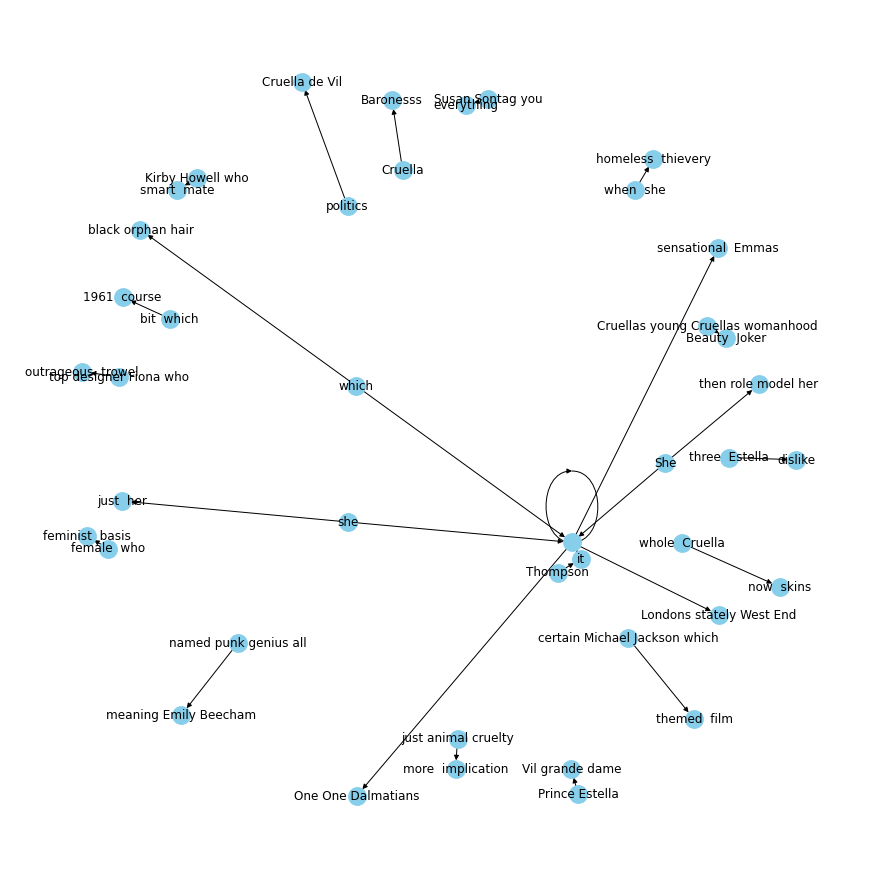

In [47]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

# Explore entities & relations for all reviews

In [61]:
movie_reviews

0    Did you ever wonder how Cruella De Vil, the va...
1    Kindly step back and make way for a sensationa...
2    In the original, animated 101 Dalmatians, ther...
3    With her shock of black-and-white hair and cri...
4    In 1996, Glenn Close glided onto screens in fu...
5    Its time to make some trouble. You in? reads o...
6    There's a lot of Cruella-splaining, much of it...
7    This live-action Disney origin story stars Emm...
8    Theres not much of One Hundred and One Dalmati...
9    Craig Gillespies Cruella explores the backstor...
Name: MovieReview, dtype: object

In [62]:
all_movie_reviews = ' '.join(movie_reviews)

In [63]:
doc = nlp(all_movie_reviews)

In [64]:
doc_sents = [str(x) for x in doc.sents]

First sentence

In [65]:
doc_sents[0]

'Did you ever wonder how Cruella De Vil, the vampy fiend from Disney\'s "101 Dalmatians," became evil enough to want to kill puppies and skin them for fur coats?'

Last sentence

In [66]:
doc_sents[-1]

'So eager to please us with sumptuous costumes and rhythmic montage, and to refresh its trademarked character by applying the same melodramatic narrative logic as countless recent properties, Cruellas outward liveliness cant mask the inner inertia it has as just another lifeless product assembled in a factory.'

In [67]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 436/436 [00:05<00:00, 82.24it/s]


In [68]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 436/436 [00:05<00:00, 80.71it/s]


In [69]:
pd.Series(relations).value_counts()[:50]

is             72
's             13
are             9
s               9
makes           6
has             5
get             5
takes           5
tells           4
comes           4
becomes         4
wants           3
was             3
brings          3
keeps           3
"               3
Wears           3
end             2
elses           2
got             2
seen            2
embraces        2
feels           2
goes            2
Is              2
wonder          2
had             2
learns          2
utters          2
think           2
is in           2
credited to     2
re              2
needs           2
blames          2
gets            2
be              2
given           2
take            2
stick           1
Cruella         1
turn bad        1
begins with     1
hear            1
fights          1
Reddys          1
calls           1
visits          1
Are             1
runs            1
dtype: int64

In [71]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [72]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [73]:
kg_df.shape

(340, 3)

In [74]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, create_using=nx.MultiDiGraph())

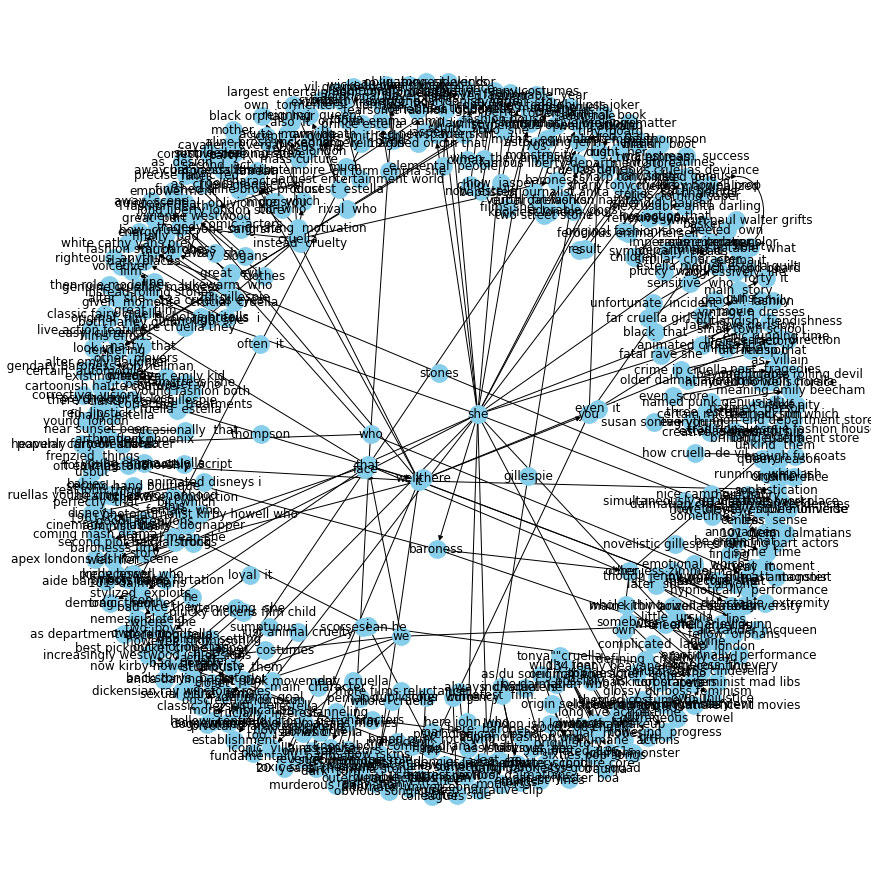

In [75]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

We could zoom in on interesting relations

In [80]:
RELATION_TO_EXPLORE = 'tells'

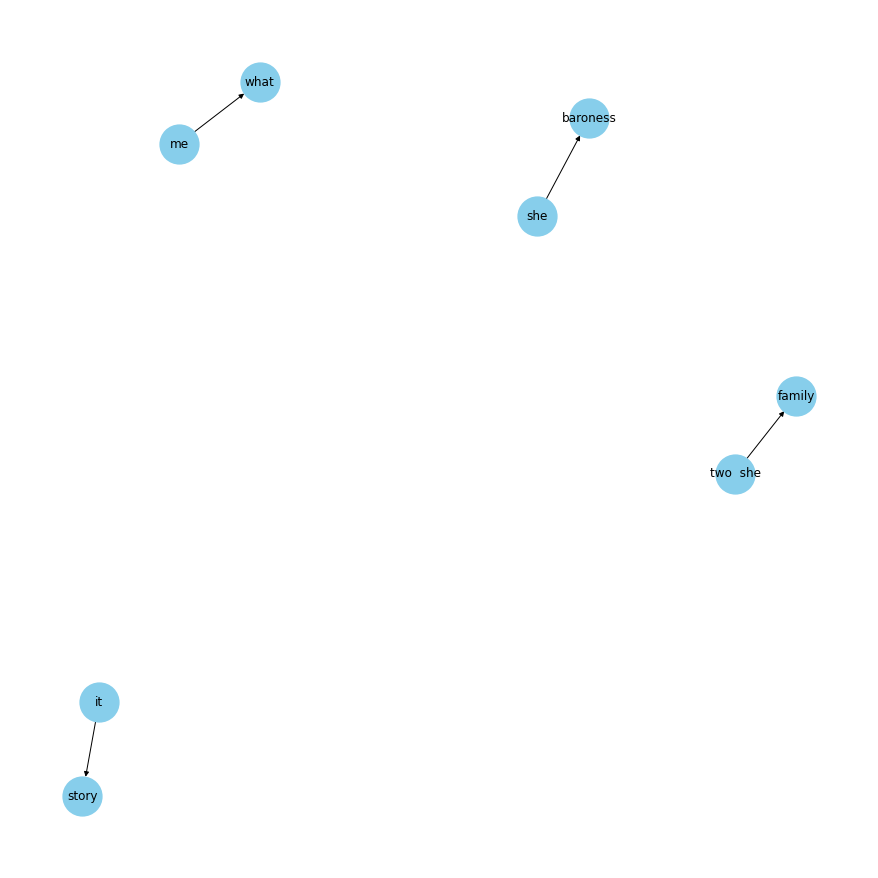

In [81]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

We could zoom in on interesting entitites

In [82]:
ENTITY_TO_EXPLORE = 'baroness'

In [83]:
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

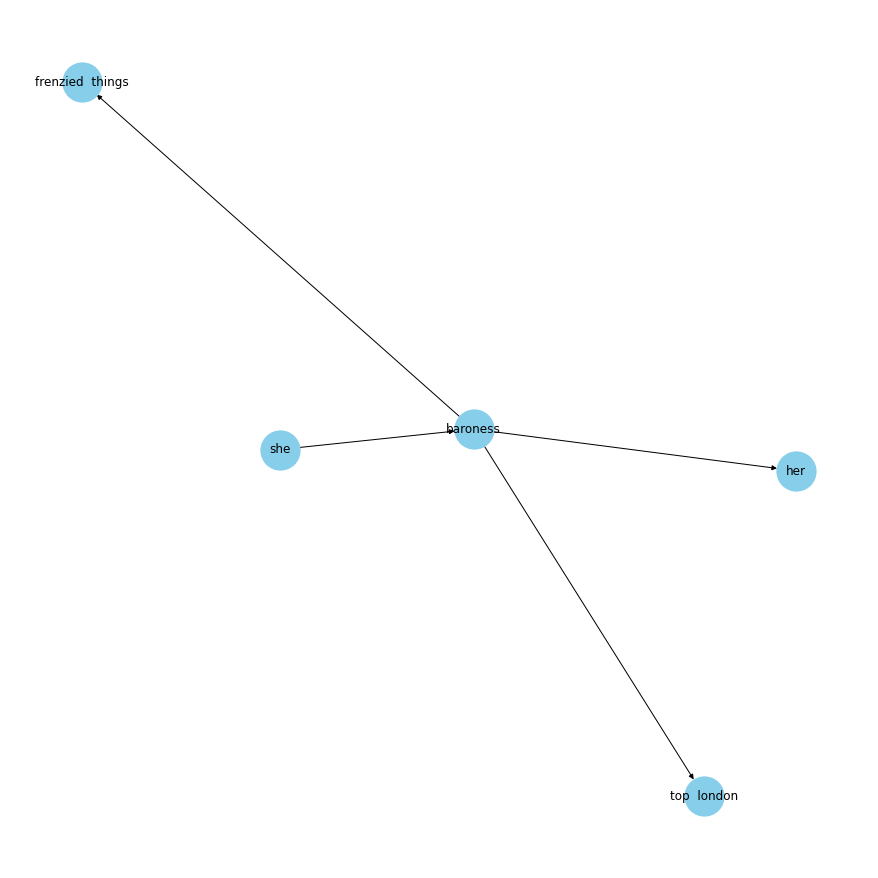

In [84]:
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

Reference:

https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook